## 3. data pre-processing and modelling
We will experiment different classification algorithms in this section, evaluate their performance and give a summary report.

Q1: Which algorithm is our best choice for this dataset?

Big data can be divided into two categories, the super long data or the super wide data. The wide data is also called high-dimensional data. Some algorithms are really good at handling such data set, for instance, support vector machine and naive bayes. Since our data set is long, we will not test these two algorithms in this experiment. Instead, we will try logistic regression, decision tree, random forest, gradient boosting, 

### 3.1 model development using df_dummy
#### 3.1.1 data pre-processing

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [46]:
dataPath='data/df_dummy.csv'
df_dummy=pd.read_csv(dataPath,index_col='ID')
df_dummy.columns

Index(['LIMIT', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'DEFAULT', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'SEX_1', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4'],
      dtype='object')

In [47]:
X= df_dummy.drop(columns=['DEFAULT'], axis=1)
X.head()

,LIMIT,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,0,0,1,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,2000,0,1,0,0,1,0,1,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,5000,0,1,0,0,1,0,1,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1000,1,0,0,0,1,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,679,1,0,0,1,0,0,1,0,0


In [48]:
X.columns

Index(['LIMIT', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'SEX_1', 'SEX_2',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4'],
      dtype='object')

In [49]:
y=df_dummy.DEFAULT
y.head()

ID
1    1
2    1
3    0
4    0
5    0
Name: DEFAULT, dtype: int64

In [50]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, stratify= y, random_state=42)

In [51]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### 3.1.2 model development

set up a function cv_optimize which takes a classifier clf, a grid of hyperparameters (such as a complexity parameter or regularization parameter) implemented as a dictionary parameters, a training set (as a samples x features array) Xtrain, and a set of labels ytrain. The code takes the traning set, splits it into n_folds parts, sets up n_folds folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and retuens the best classifier to us.

We then use this best classifier to fit the entire training set. This is done inside the do_classify function which takes a dataframe indf as input. It takes the columns in the list featurenames as the features used to train the classifier. The column targetname sets the target. The classification is done by setting those samples for which targetname has value target1val to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation. We then train the model on the training set using cross-validation. Having obtained the best classifier using cv_optimize, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

#### 3.1.2.1 regularized logistic regression
Binary logistic regression is the simplest classification algorithms. But it cannot perform very well when there are colinearity between predictors. It is also vulnerable to overfitting. As we explored the correlation between predictors in section1, there is some colinearity between predictor features in this data set. Hence, we decided to use regularized logistic regression and use RandomizedSearchCV( ) to find the best value of the hyperparameter, [C](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [52]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import time
start=time.time()
logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]} # C is the inverse of regularization strength; must be a positive float. Smaller values of C mean stronger regularization.
logreg_cv = RandomizedSearchCV(logreg, param_grid , cv=5, random_state=42)
logreg_cv.fit(X_train_scaled,y_train)
end=time.time()
print("BEST PARAMS", logreg_cv.best_params_)
print(f"Runtime of the program is {end - start}")

BEST PARAMS {'C': 10}
Runtime of the program is 5.437450408935547


Text(0.5, 15.0, 'Predicted label')

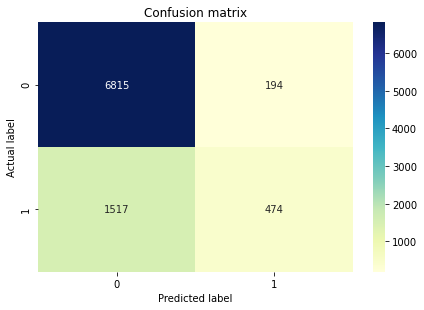

In [53]:
# use the best C value, 10, to develop regularized logistic regression model
best_C_logreg=logreg_cv.best_estimator_
y_pred=best_C_logreg.predict(X_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [54]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8098888888888889
Precision: 0.7095808383233533
Recall: 0.23807132094424913


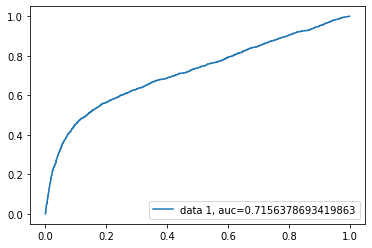

In [55]:
y_pred_proba = best_C_logreg.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

There are [three ways](https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f) to rank features in a Logistic Regression model. They are by coefficient values, recursive feature elimination (RFE) and sci-kit Learn’s SelectFromModels (SFM). Here, we only try two of them.
1. First, coefficients. The higher the coefficient, the higher the “importance” of a feature. 

In [56]:
best_C_logreg.coef_

array([[-0.11077078,  0.03616903,  0.65381198,  0.10295481,  0.08424131,
         0.05654514,  0.01586842,  0.02120401, -0.31996178,  0.01411706,
         0.10674377,  0.03745503,  0.01144339,  0.03250345, -0.15387537,
        -0.25470201, -0.02335611, -0.04620155, -0.02239685, -0.03847854,
         0.0492499 , -0.05028647,  0.00507227,  0.02726772, -0.02726772,
         0.05390547, -0.00424052, -0.01639234, -0.13748926]])

In [57]:
X.columns

Index(['LIMIT', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'SEX_1', 'SEX_2',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4'],
      dtype='object')

2. select the most important features from the model

In [58]:
from sklearn.feature_selection import SelectFromModel
sfm=SelectFromModel(best_C_logreg, threshold=-np.inf, max_features=5)
sfm.fit(X_train_scaled, y_train)
feature_idx=sfm.get_support()
feature_name=X.columns[feature_idx]
feature_name

Index(['PAY_1', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'EDUCATION_4'], dtype='object')

#### 3.1.2.2 decision tree

Usually, the tree complexity is measured by one of the following metrics: the number of nodes, the number of leaves, tree depth and attributes used. It is a little bit complicated to tune [all hyperparameters in decision tree](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680). Here we only experiment criterion and max_depth

In [59]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[3, 5]}

In [60]:
def tree_optimization(cri, max_d):
    model = DecisionTreeClassifier(criterion=cri, max_depth = max_d, random_state = 42)
    model.fit(X_train_scaled, y_train)
    y_pred=model.predict(X_test_scaled)
    Accuracy=np.round(metrics.accuracy_score(y_test, y_pred),2)
    Precision=np.round(metrics.precision_score(y_test, y_pred),2)
    Recall=np.round(metrics.recall_score(y_test, y_pred),2)
    return cri, max_d, Accuracy, Precision, Recall

In [61]:
tree_optimization('gini', 3)

('gini', 3, 0.82, 0.66, 0.36)

In [62]:
tree_optimization('gini', 5)

('gini', 5, 0.82, 0.66, 0.34)

In [63]:
tree_optimization('entropy', 3)

('entropy', 3, 0.82, 0.66, 0.36)

In [64]:
tree_optimization('entropy', 5)

('entropy', 5, 0.82, 0.67, 0.35)

Text(0.5, 15.0, 'Predicted label')

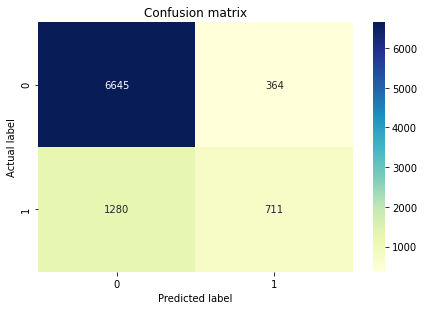

In [65]:
#These models gave us similar results. We will use gini with max_depth=3 to check our decision tree model.
model = DecisionTreeClassifier(criterion='gini', max_depth = 3, random_state = 42)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[::,1]
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [66]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8173333333333334
Precision: 0.6613953488372093
Recall: 0.3571069814163737


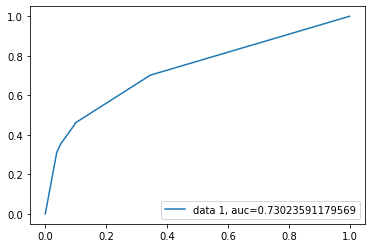

In [67]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

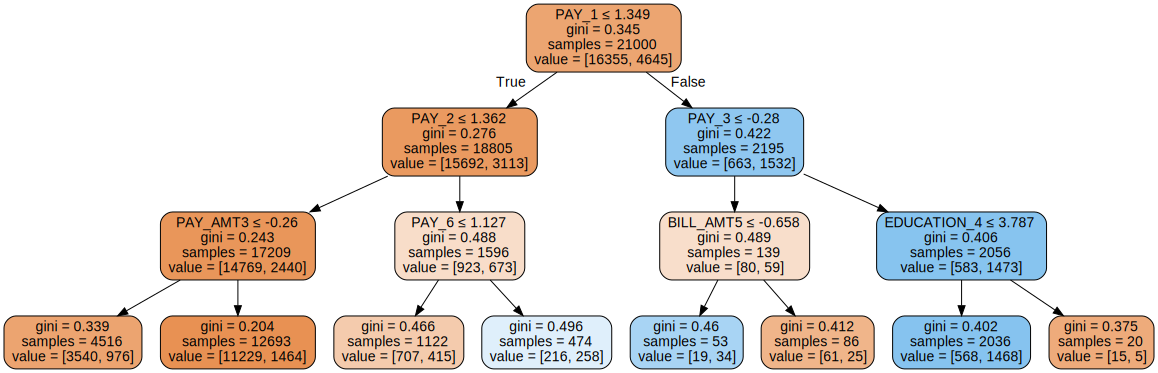

In [68]:
#Let's check the importance of features in this model
dot_data = export_graphviz(model, out_file = None, feature_names = X.columns, filled = True, rounded = True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [69]:
fea_importance=dict(zip(X.columns, np.round(model.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'LIMIT': 0.0, 'AGE': 0.0, 'PAY_4': 0.0, 'PAY_5': 0.0, 'BILL_AMT1': 0.0, 'BILL_AMT2': 0.0, 'BILL_AMT3': 0.0, 'BILL_AMT4': 0.0, 'BILL_AMT6': 0.0, 'PAY_AMT1': 0.0, 'PAY_AMT2': 0.0, 'PAY_AMT4': 0.0, 'PAY_AMT5': 0.0, 'PAY_AMT6': 0.0, 'MARRIAGE_1': 0.0, 'MARRIAGE_2': 0.0, 'MARRIAGE_3': 0.0, 'SEX_1': 0.0, 'SEX_2': 0.0, 'EDUCATION_1': 0.0, 'EDUCATION_2': 0.0, 'EDUCATION_3': 0.0, 'PAY_6': 0.01, 'BILL_AMT5': 0.01, 'EDUCATION_4': 0.01, 'PAY_3': 0.02, 'PAY_AMT3': 0.05, 'PAY_2': 0.16, 'PAY_1': 0.76}


Based on the tree plot above and feature importance attribute, we can say PAY_1, PAY_2, PAY_AMT3, and PAY_3 are the most important features.

#### 3.1.2.3 random forest

random forest = many decison trees + many bagging. Because random forest is an ensemble of desion trees, it has all the hyperparameters of DecisionTreeClassifier and BaggingClassifers. Also as an ensemble algorithms, random forest can greatly improve the accuracy of prediction compared with a SINGLE decision tree.

We will optimize the following hyperparameters in the random forest model: 
* n_estimators = number of trees in the random forest model
* max_depth = max_depth in each decision tree

In [70]:
from sklearn.ensemble import RandomForestClassifier
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
start=time.time()
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_scaled, y_train)
end=time.time()
print("BEST PARAMS", rf_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


BEST PARAMS {'n_estimators': 200, 'max_depth': 9}
Runtime of the program is 83.23094153404236


Text(0.5, 15.0, 'Predicted label')

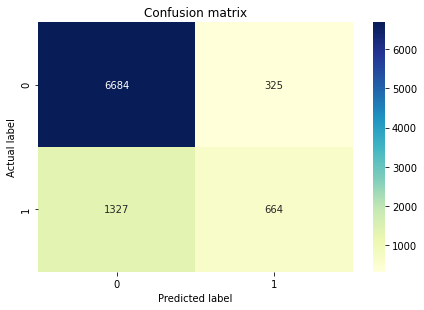

In [71]:
best_rf=rf_random.best_estimator_
y_pred=best_rf.predict(X_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [72]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8164444444444444
Precision: 0.6713852376137512
Recall: 0.33350075339025614


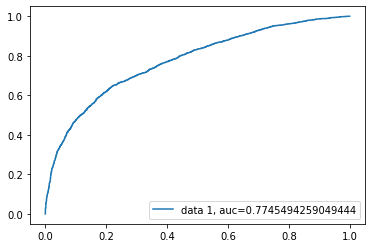

In [73]:
y_pred_proba = best_rf.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [74]:
fea_importance=dict(zip(X.columns, np.round(best_rf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'MARRIAGE_1': 0.0, 'MARRIAGE_2': 0.0, 'MARRIAGE_3': 0.0, 'SEX_1': 0.0, 'SEX_2': 0.0, 'EDUCATION_1': 0.0, 'EDUCATION_2': 0.0, 'EDUCATION_3': 0.0, 'EDUCATION_4': 0.0, 'AGE': 0.02, 'BILL_AMT3': 0.02, 'BILL_AMT4': 0.02, 'BILL_AMT5': 0.02, 'BILL_AMT6': 0.02, 'PAY_AMT4': 0.02, 'PAY_AMT5': 0.02, 'PAY_AMT6': 0.02, 'BILL_AMT1': 0.03, 'BILL_AMT2': 0.03, 'PAY_AMT2': 0.03, 'PAY_AMT3': 0.03, 'LIMIT': 0.04, 'PAY_6': 0.04, 'PAY_AMT1': 0.04, 'PAY_5': 0.05, 'PAY_4': 0.06, 'PAY_3': 0.08, 'PAY_2': 0.12, 'PAY_1': 0.27}


The top 5 important features are PAY_1, PAY_2, PAY_3, PAY_4 and PAY_5.

#### 3.1.2.4 gradient boosting

gradient boosting = decision tree + boosting. Just like random forest, [the parameters of gradient boosting](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) includes both decision tree specific parameters and boosting parameters. Compared with random forest, gradient boosting not only controls for high variance in a model, but also control the bias. Therefore, it is regarded as a more effective algorithms. The disadvantage of this algorithms is its time-consuming.

We choose three important hyperparameters to tune this model:
* learning_rate
* n_estimator
* max_depth

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
start=time.time()
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
gbm_random.fit(X_train_scaled, y_train)
end=time.time()
print("BEST PARAMS", gbm_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.4min finished


BEST PARAMS {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
Runtime of the program is 988.605076789856


Text(0.5, 15.0, 'Predicted label')

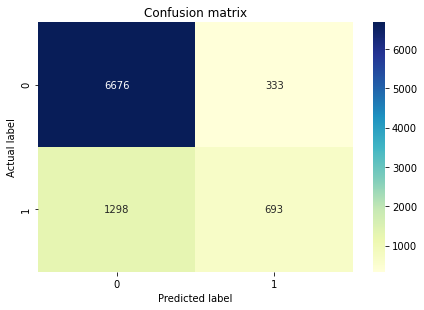

In [76]:
best_gbm=gbm_random.best_estimator_
y_pred=best_gbm.predict(X_test_scaled)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [77]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8187777777777778
Precision: 0.6754385964912281
Recall: 0.34806629834254144


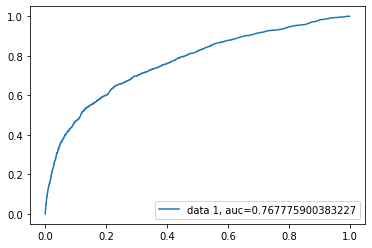

In [78]:
y_pred_proba = best_gbm.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [79]:
fea_importance=dict(zip(X.columns, np.round(best_gbm.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'AGE': 0.0, 'BILL_AMT2': 0.0, 'BILL_AMT3': 0.0, 'BILL_AMT4': 0.0, 'BILL_AMT5': 0.0, 'BILL_AMT6': 0.0, 'PAY_AMT4': 0.0, 'PAY_AMT5': 0.0, 'MARRIAGE_1': 0.0, 'MARRIAGE_2': 0.0, 'MARRIAGE_3': 0.0, 'SEX_1': 0.0, 'SEX_2': 0.0, 'EDUCATION_1': 0.0, 'EDUCATION_2': 0.0, 'EDUCATION_3': 0.0, 'EDUCATION_4': 0.0, 'BILL_AMT1': 0.01, 'PAY_AMT1': 0.01, 'PAY_AMT6': 0.01, 'LIMIT': 0.02, 'PAY_4': 0.02, 'PAY_6': 0.02, 'PAY_AMT2': 0.02, 'PAY_AMT3': 0.02, 'PAY_3': 0.04, 'PAY_5': 0.04, 'PAY_2': 0.07, 'PAY_1': 0.71}


The top five important features are PAY_1, PAY_2, PAY_5, PAY_3 and PAY_AMT3

#### 3.1.2.5 Extreme Gradient Boosting (XGBoost)

XGBoost is short for “eXtreme Gradient Boosting.” The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting

In [ ]:
import xgboost as xgb
#check datacamp training course for more information before model development

#### 3.1.2.6 KNN

The k-nearest neighbors algorithm (KNN) is a non-parametric method used for classification. To calculate distances, 3 distance metrics that are often used are Euclidean Distance, Manhattan Distance, and Minkowski Distance. Here, we will test euclidean distance and manhattan distance.

We will tune two hyperparameters in knn, n_neighbors and p. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. 

In [80]:
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = list(range(2,30))
p=[1,2]
param_grid ={'leaf_size':leaf_size, 'n_neighbors':n_neighbors, 'p':p}
knn = KNeighborsClassifier()
start=time.time()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train_scaled, y_train)
end=time.time()
print("BEST PARAMS", knn_random.best_params_)
print(f"Runtime of the program is {end - start}")

NameError: name 'reg_knn' is not defined

In [ ]:
#what if I try gridsearch?
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)

### 3.2 define functions for tuning hyperparameters in classification model and evaluate model performance

In [8]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [9]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, random_state=1)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

#check the training course from datacamp about hyperparameter tuning in machine learning

### 3.3 summary